# **`INSTALLATIONS`**

In [98]:
#Installing and importing dask

DASK_IMPORTED = False

try:
    import dask
    import dask.dataframe as dd
except ModuleNotFoundError:
   print ("Trying to to install dask")
   %pip install "dask[complete]"
   import dask
   import dask.dataframe as dd



try:
    import dask
    import dask.dataframe as dd
    DASK_IMPORTED = True
except ModuleNotFoundError:
    pass
   

In [ ]:
#Installing and importing codetiming

CODETIMIMG_IMPORTED = False


try:
    import codetiming
except ModuleNotFoundError:
   print ("Trying to to install codetiming")
   %pip install codetiming
   import codetiming


try:
    import codetiming
    CODETIMIMG_IMPORTED = True
except ModuleNotFoundError:
    pass

# **IMPORTS**

In [ ]:
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import random
from datetime import date, datetime, timedelta


# **DETECTING COLAB**

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
# Mounting drive using the following commands:

if IN_COLAB == True :
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **FILE'S PATH**

In [ ]:
myPath = "/content/drive/My Drive/Colab Notebooks/gorilla/gorilla_test_data.xlsx"

# **LOADING AND PREPARING DATA**

In [ ]:
#Reading data
df_meter_list = pd.read_excel(myPath, sheet_name='meter_list')
df_forecast_table = pd.read_excel(myPath, sheet_name='forecast_table')
df_rate_table = pd.read_excel(myPath, sheet_name='rate_table')

In [ ]:
#Treating nans
df_rate_table["aq_min_kwh"].fillna(-np.inf, inplace = True)
df_rate_table["aq_max_kwh"].fillna(np.inf, inplace = True) 

In [ ]:
#I want to differentiate between reference date for calculation and tariff efect
df_rate_table.rename(columns={'date': 'date_rate'}, inplace=True)

In [ ]:
#Dask DataFrames
if DASK_IMPORTED == True :
  ddf_meter_list = dd.from_pandas(df_meter_list, npartitions=10)
  ddf_forecast_table = dd.from_pandas(df_forecast_table, npartitions=10)
  ddf_rate_table = dd.from_pandas(df_rate_table, npartitions=10)

In [ ]:
def agg_sum(variable):  
    variable_sum = variable.mean()  
    return round(variable_sum, 2)

# **Calculating Transportation Cost Table Apply Functions**

In [ ]:
def update_rating_tariff(row , tariff_table):
  
  reference_date = row['date'] 
  aq_kwh = row['aq_kwh'] 
  exit_zone = row['exit_zone']

  #Filtering by Constraints
  tariff_table_filtered = tariff_table[(tariff_table['exit_zone'] == exit_zone) & (tariff_table['date_rate'] <= reference_date) & (aq_kwh >= tariff_table['aq_min_kwh']) & (aq_kwh <= tariff_table['aq_max_kwh'])]

  #Recovering the last valid tariff by date rate
  tariff_table_filtered_max_date = tariff_table_filtered[tariff_table_filtered['date_rate'] == tariff_table_filtered.date_rate.max()]
  result = tariff_table_filtered_max_date[:1]['rate_p_per_kwh'].values[0]
  row['rate_p_per_kwh'] = result

  return row



In [ ]:
def transportation_cost_table_with_apply(df_rate_table = None, df_meter_list  = None, df_forecast_table  = None):

  #Composing data of meters
  df_forecast_table_op1 =  pd.merge(df_forecast_table, df_meter_list, how="left", on=["meter_id"])
  
  #Adding the rate_p_per_kwh
  df_forecast_table_op1['rate_p_per_kwh'] = 0.0

  df_forecast_table_op1 = df_forecast_table_op1.apply(lambda x: update_rating_tariff(row = x, tariff_table = df_rate_table ), axis = 1)

  #Cost (£)
  df_forecast_table_op1['Cost£'] = df_forecast_table_op1['kwh'] * df_forecast_table_op1['kwh'] * 0.01

  tcostTable = df_forecast_table_op1[['meter_id','kwh','Cost£']].groupby('meter_id').agg(agg_sum)

  return tcostTable 

In [ ]:

if DASK_IMPORTED == True :

  def dask_transportation_cost_table_with_apply(ddf_rate_table = None, ddf_meter_list  = None, ddf_forecast_table  = None):

    #Composing data of meters
    ddf_forecast_table_op1 =  ddf_forecast_table.merge(ddf_meter_list, how="left", on=["meter_id"])
  
    #Adding the rate_p_per_kwh
    ddf_forecast_table_op1['rate_p_per_kwh'] = 0.0

    ddf_forecast_table_op1 = ddf_forecast_table_op1.apply(lambda x: update_rating_tariff(row = x, tariff_table = df_rate_table ), axis = 1, meta=ddf_forecast_table_op1)

    #Cost (£)
    ddf_forecast_table_op1['Cost£'] = ddf_forecast_table_op1['kwh'] * ddf_forecast_table_op1['kwh'] * 0.01

    custom_agg = dd.Aggregation('custom_agg', chunk = agg_sum, agg = agg_sum)
    tcostTable = ddf_forecast_table_op1[['meter_id','kwh','Cost£']].groupby('meter_id').agg(custom_agg)

    return tcostTable 

# **Calculating Transportation Cost Table Merge Functions**

In [ ]:
  df_forecast_table_c = df_forecast_table.copy()
  df_meter_list_c = df_meter_list.copy()
  df_forecast_table_c.set_index('meter_id', inplace=True)
  df_meter_list_c.set_index('meter_id', inplace=True)
  df_forecast_table_op1 =  pd.merge(df_forecast_table, df_meter_list, right_index= True, left_index= True, how="left")


In [ ]:
def transportation_cost_table_with_merge(df_rate_table = None, df_meter_list  = None, df_forecast_table  = None):

  #Composing data of meters
  df_forecast_table_op1 =  pd.merge(df_forecast_table, df_meter_list, how="left", on=["meter_id"])

  df_unique_parameters_to_rate = df_forecast_table_op1.drop(columns=['meter_id', 'kwh']).groupby(['date','exit_zone', 'aq_kwh']).count().reset_index()
  df_unique_parameters_to_rate.drop_duplicates(inplace=True)

  #Adding parameters from tariff
  df_unique_parameters_to_rate = pd.merge(df_unique_parameters_to_rate, df_rate_table, how="left", on=['exit_zone'])

  df_unique_parameters_to_rate.drop_duplicates(inplace=True)

  #Reducing by constraints
  df_unique_parameters_to_rate = df_unique_parameters_to_rate[(df_unique_parameters_to_rate['date_rate'] <= df_unique_parameters_to_rate['date']) & (df_unique_parameters_to_rate['aq_kwh'] >= df_unique_parameters_to_rate['aq_min_kwh']) & (df_unique_parameters_to_rate['aq_kwh'] <= df_unique_parameters_to_rate['aq_max_kwh'])]

  #We do not need 'aq_min_kwh' & 'aq_max_kwh'
  df_unique_parameters_to_rate.drop(columns=['aq_min_kwh','aq_max_kwh'], inplace=True)

  #Selecting as valid rate the correpondant with the last rating date
  df_unique_parameters_to_rate_op1 = df_unique_parameters_to_rate.groupby(['date','exit_zone', 'aq_kwh'], sort=False)['date_rate'].max().reset_index(name='date_rate')
  df_unique_parameters_to_rate_op1.drop_duplicates(inplace=True)

  #Restoring rate_p_per_kwh
  df_unique_parameters_to_rate = pd.merge(df_unique_parameters_to_rate_op1,df_unique_parameters_to_rate,  how="left", on=['date','date_rate','exit_zone', 'aq_kwh'])

  df_forecast_table_op2 =  pd.merge(df_forecast_table_op1, df_unique_parameters_to_rate, how="left", on=['date','exit_zone', 'aq_kwh'])

  #Cost (£)
  df_forecast_table_op2['Cost£'] = df_forecast_table_op2['kwh'] * df_forecast_table_op2['kwh'] * 0.01

  tcostTable = df_forecast_table_op2[['meter_id','kwh','Cost£']].groupby('meter_id').agg(agg_sum)

  return tcostTable 



In [ ]:
if DASK_IMPORTED == True :

  def dask_transportation_cost_table_with_merge(ddf_rate_table = None, ddf_meter_list  = None, ddf_forecast_table  = None):

    #Composing data of meters
    ddf_forecast_table_op1 =  ddf_forecast_table.merge(df_meter_list, how="left", on=["meter_id"])

    ddf_unique_parameters_to_rate = ddf_forecast_table_op1.drop(columns=['meter_id', 'kwh']).groupby(['date','exit_zone', 'aq_kwh']).count().reset_index()
    ddf_unique_parameters_to_rate.drop_duplicates(inplace=True)

    #Adding parameters from tariff
    ddf_unique_parameters_to_rate = ddf_unique_parameters_to_rate.merge(ddf_rate_table, how="left", on=['exit_zone'])

    ddf_unique_parameters_to_rate.drop_duplicates(inplace=True)

    #Reducing by constraints
    ddf_unique_parameters_to_rate = ddf_unique_parameters_to_rate[(ddf_unique_parameters_to_rate['date_rate'] <= ddf_unique_parameters_to_rate['date']) & (ddf_unique_parameters_to_rate['aq_kwh'] >= ddf_unique_parameters_to_rate['aq_min_kwh']) & (ddf_unique_parameters_to_rate['aq_kwh'] <= ddf_unique_parameters_to_rate['aq_max_kwh'])]

    #We do not need 'aq_min_kwh' & 'aq_max_kwh'
    ddf_unique_parameters_to_rate = ddf_unique_parameters_to_rate.drop(columns=['aq_min_kwh','aq_max_kwh'])

    #Selecting as valid rate the correpondant with the last rating date
    ddf_unique_parameters_to_rate_op1 = ddf_unique_parameters_to_rate.groupby(['date','exit_zone', 'aq_kwh'], sort=False)['date_rate'].max().compute().reset_index()
    #ddf_unique_parameters_to_rate_op1 = ddf_unique_parameters_to_rate_op1.compute()
    ddf_unique_parameters_to_rate_op1 = ddf_unique_parameters_to_rate_op1.rename(columns={'index': 'date_rate'})
    ddf_unique_parameters_to_rate_op1 = dd.from_pandas(ddf_unique_parameters_to_rate_op1, npartitions=10)


    print(ddf_unique_parameters_to_rate_op1.columns)
    #print(ddf_unique_parameters_to_rate_op1.shape[0]) 
  
    ddf_unique_parameters_to_rate_op1 = ddf_unique_parameters_to_rate_op1.drop_duplicates()

    #Restoring rate_p_per_kwh
    ddf_unique_parameters_to_rate = ddf_unique_parameters_to_rate_op1.merge(ddf_unique_parameters_to_rate,  how="left", on=['date','date_rate','exit_zone', 'aq_kwh'])

    ddf_forecast_table_op2 =  ddf_forecast_table_op1.merge(ddf_unique_parameters_to_rate, how="left", on=['date','exit_zone', 'aq_kwh'])

    #Cost (£)
    ddf_forecast_table_op2['Cost£'] = ddf_forecast_table_op2['kwh'] * ddf_forecast_table_op2['kwh'] * 0.01

    custom_agg = dd.Aggregation('custom_agg', chunk = agg_sum, agg = agg_sum)
    tcostTable = ddf_forecast_table_op2[['meter_id','kwh','Cost£']].groupby('meter_id').agg(custom_agg).compute()

    return tcostTable 

# **FIRST EXERCISE**

# **Using Apply**

In [ ]:
transportation_cost_table = transportation_cost_table_with_apply(df_rate_table, df_meter_list, df_forecast_table)
transportation_cost_table.head()

,kwh,Cost£
meter_id,,
14676236,33.97,13.84
34509937,91.82,102.64
50264822,311.45,1216.58
88357331,567.88,3884.36


# **Using Apply with Dask**

In [ ]:
if DASK_IMPORTED == True :

  ddf_transportation_cost_table = dask_transportation_cost_table_with_apply(ddf_rate_table, ddf_meter_list, ddf_forecast_table)
  

In [ ]:

ddf_transportation_cost_table.head()

/usr/local/lib/python3.7/dist-packages/dask/dataframe/core.py:5970: UserWarning: Insufficient elements for `head`. 5 elements requested, only 4 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,kwh,Cost£
meter_id,,
34509937,91.82,102.64
50264822,311.45,1216.58
88357331,567.88,3884.36
14676236,33.97,13.84


# **Using Merges**

In [ ]:
transportation_cost_table = transportation_cost_table_with_merge(df_rate_table, df_meter_list, df_forecast_table)
transportation_cost_table.head()

,kwh,Cost£
meter_id,,
14676236,33.97,13.84
34509937,91.82,102.64
50264822,311.45,1216.58
88357331,567.88,3884.36


# **Using Merges with Dask**

In [ ]:
if DASK_IMPORTED == True :

  ddf_transportation_cost_table = dask_transportation_cost_table_with_merge(ddf_rate_table, ddf_meter_list, ddf_forecast_table)
  ddf_transportation_cost_table.head()

Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')


# **SECOND EXERCISE**

# **Synthetic Meters Functions**

In [ ]:
def ramdom_meter(row_meter, min_annual, max_annual, list_exit_zones):
  exit_zone = random.choice(list_exit_zones)
  #meter_id = random.choice(list_ids)
  aq_kwh = random.randint(min_annual, max_annual)
  row_meter['exit_zone'] = exit_zone
  row_meter['aq_kwh'] = aq_kwh
  return row_meter

def synthetic_meter_df(minid, maxid, metersSize, rate_table):
  meters_size = metersSize
  min_id = minid
  max_id = maxid
  exit_zones_list = rate_table['exit_zone'].unique()
  meter_id_list = random.sample(range(min_id, max_id), meters_size)
  df_synth_meters = DataFrame(meter_id_list, columns = ['meter_id'])

  #Adding the exit_code
  df_synth_meters['exit_zone'] = ''
  df_synth_meters['aq_kwh'] = 0.0
  
  df_synth_meters = df_synth_meters.apply(lambda x: ramdom_meter(row_meter = x, min_annual = 100, max_annual = 9999, list_exit_zones =  exit_zones_list), axis = 1)
  return df_synth_meters




# **Test**

In [ ]:
df_synth_meters = synthetic_meter_df(0, 999999, 10, df_rate_table)
df_synth_meters.head()

,meter_id,exit_zone,aq_kwh
0,1521,SW3,2377
1,981773,LW,2820
2,350479,NW2,8080
3,191080,NE2,4047
4,663973,SC4,8879


In [ ]:
print(df_synth_meters.columns)

Index(['meter_id', 'exit_zone', 'aq_kwh'], dtype='object')


# **THIRD EXERCISE**

# **Synthetic Consumption Functions**

In [ ]:
def date_range(start_date, days_duration):
    dates = [start_date + timedelta(days=i) for i in range(days_duration + 1)]
    return dates

In [ ]:


def ramdom_consum(row_forecast, min_consum, max_consum):
  kwh = random.randint(min_consum, max_consum)
  row_forecast['kwh'] = kwh
  return row_forecast





def mock_consumption_df(start_date, duration, meters_ids):

  list_dates = date_range(start_date, duration)

  df_meters_ids = DataFrame(meters_ids, columns = ['meter_id'])
  df_dates = DataFrame(list_dates, columns = ['date'])
  df_meters_ids['tmp'] = 1
  df_dates['tmp'] = 1

  df_synth_forecast = pd.merge(df_meters_ids,df_dates, on=['tmp'])
  df_synth_forecast.drop('tmp', axis=1, inplace = True)


  df_synth_forecast['kwh'] = 0.0
  df_synth_forecast = df_synth_forecast.apply(lambda x: ramdom_consum(row_forecast = x, min_consum = 10, max_consum = 60), axis = 1)

  return df_synth_forecast



# **Test**

In [ ]:
today = datetime.combine(date.today(), datetime.min.time())

df_synth_forecast = mock_consumption_df(today, 10, df_synth_meters['meter_id'].unique()) 
df_synth_forecast.head()

,meter_id,date,kwh
0,1521,2022-08-15,39
1,1521,2022-08-16,24
2,1521,2022-08-17,52
3,1521,2022-08-18,54
4,1521,2022-08-19,14


# **FOURTH EXERCISE (Benchmark)**

# **Multiple mocks with several numbers of meters up to 300 and 175 days of duration**

In [ ]:
DURATION = 175
MAX_NUMBERS_OF_METERS =300

totalmeterListSizes = range(0,MAX_NUMBERS_OF_METERS)

today = datetime.combine(date.today(), datetime.min.time())
meterListSizes = random.choices(totalmeterListSizes, k=10)
meterListSizes.sort()

meters_df_l = []
mock_consumption_df_l = [] 

meters_ddf_l = []
mock_consumption_ddf_l = [] 


for listSize in meterListSizes:
  df_synth_meters_op = synthetic_meter_df(0, 999999, listSize, df_rate_table)
  df_synth_forecast = mock_consumption_df(today, DURATION, df_synth_meters_op['meter_id'].unique()) 
  
  if DASK_IMPORTED == True :
    ddf_synth_forecast = dd.from_pandas(df_synth_forecast, npartitions=10)
    ddf_synth_meters_op = dd.from_pandas(df_synth_meters_op, npartitions=10)
  
  meters_df_l.append(df_synth_meters_op.copy())
  mock_consumption_df_l.append(df_synth_forecast.copy())

  if DASK_IMPORTED == True :
    meters_ddf_l.append(ddf_synth_meters_op)
    mock_consumption_ddf_l.append(ddf_synth_forecast)


# **GENERATING Transportation Cost Tables to capture TIMES FOR BENCHMARK**

In [ ]:
from codetiming import Timer

t_apply = Timer(name="Apply Function", text="Apply Elapsed time: {milliseconds:.0f} ms")
t_dask_apply = Timer(name="Dask Apply Function", text="Dask Apply Elapsed time: {milliseconds:.0f} ms")
t_merge = Timer(name="Merge Function", text="Merge Elapsed time: {milliseconds:.0f} ms")
t_dask_merge = Timer(name="Dask Merge Function", text="Dask Merge Elapsed time: {milliseconds:.0f} ms")

size = []
time_merge = []
time_dask_merge = []
time_apply = []
time_dask_apply = []

for i in range(len(meters_df_l)):
  t_merge.start()
  transportation_cost_table_with_merge(df_rate_table , meters_df_l[i] , mock_consumption_df_l[i])
  t_merge.stop()
  time_merge.append(t_merge.last)
  size.append(meters_df_l[i].shape[0])

  if DASK_IMPORTED == True :  
    t_dask_merge.start()
    dask_transportation_cost_table_with_merge(ddf_rate_table , meters_ddf_l[i] , mock_consumption_ddf_l[i])
    t_dask_merge.stop()
    time_dask_merge.append(t_dask_merge.last)


  t_apply.start()
  transportation_cost_table_with_apply(df_rate_table , meters_df_l[i] , mock_consumption_df_l[i])
  t_apply.stop()
  time_apply.append(t_apply.last)

  if DASK_IMPORTED == True :
    t_dask_apply.start()
    dask_transportation_cost_table_with_apply(ddf_rate_table , meters_ddf_l[i] , mock_consumption_ddf_l[i])
    t_dask_apply.stop()
    time_dask_apply.append(t_dask_apply.last)


Merge Elapsed time: 145 ms
Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')
Dask Merge Elapsed time: 1604 ms
Apply Elapsed time: 13414 ms
Dask Apply Elapsed time: 49 ms
Merge Elapsed time: 339 ms
Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')
Dask Merge Elapsed time: 1647 ms
Apply Elapsed time: 44426 ms
Dask Apply Elapsed time: 175 ms
Merge Elapsed time: 1013 ms
Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')
Dask Merge Elapsed time: 1714 ms
Apply Elapsed time: 68769 ms
Dask Apply Elapsed time: 54 ms
Merge Elapsed time: 547 ms
Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')
Dask Merge Elapsed time: 1709 ms
Apply Elapsed time: 75836 ms
Dask Apply Elapsed time: 61 ms
Merge Elapsed time: 557 ms
Index(['date', 'exit_zone', 'aq_kwh', 'date_rate'], dtype='object')
Dask Merge Elapsed time: 2068 ms
Apply Elapsed time: 72927 ms
Dask Apply Elapsed time: 49 ms
Merge Elapsed time: 663 ms
Index(['date', 'exit_zone', 'aq

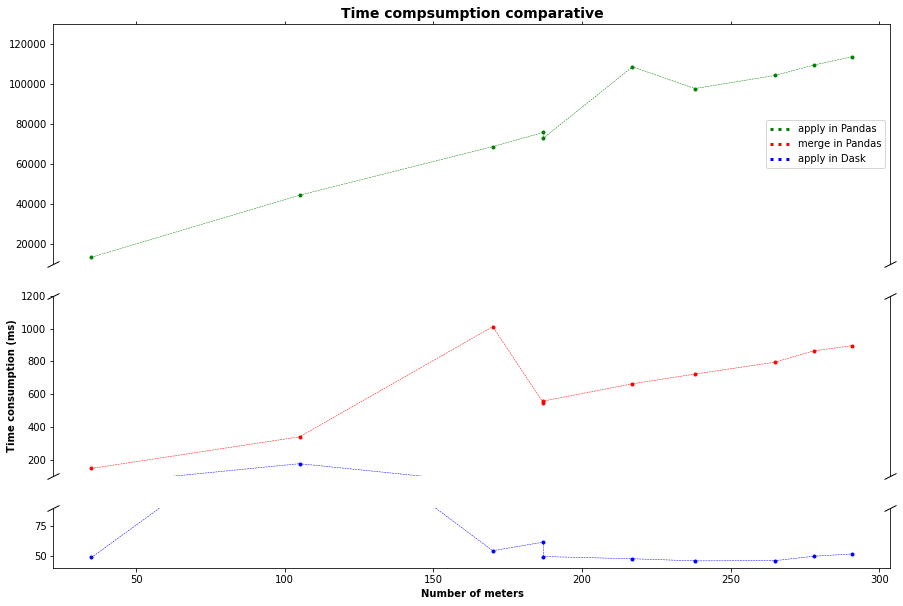

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

time_merge_rounded_map = map(lambda x: round(x * 1000,2), time_merge)
time_apply_rounded_map = map(lambda x: round(x * 1000,2), time_apply)
time_dask_apply_rounded_map = map(lambda x:  round(x * 1000,2), time_dask_apply)

time_merge_rounded = list(time_merge_rounded_map)
time_apply_rounded = list(time_apply_rounded_map)
time_dask_apply_rounded = list(time_dask_apply_rounded_map)

# Plotting functions
def plot_ax(ax):
    ax.plot(size,  time_merge_rounded, 'r.', linewidth=.5, linestyle="--")
    ax.plot(size, time_apply_rounded, 'g.', linewidth=.5, linestyle="--")
    ax.plot(size, time_dask_apply_rounded, 'b.', linewidth=.5, linestyle="--")



def plot_performances():

  # Draw the graph on two subplots
  # Bottom graph is twice the size of the top one
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2,1.5, 0.5]}, figsize=(15, 10))
  plot_ax(ax1)
  plot_ax(ax2)
  plot_ax(ax3)


  # Changes graph axes
  ax1.set_ylim(10000, 130000) # Top graph
  ax2.set_ylim(100, 1200) # Bottom graph
  ax3.set_ylim(40, 90) # Bottom graph



  # Hides the spines between the axes
  ax1.spines['bottom'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax2.spines['bottom'].set_visible(False) 
  ax3.spines['top'].set_visible(False)

  ax1.xaxis.tick_top()
  ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
  ax2.tick_params(labelbottom=False, bottom=False)
  #ax2.xaxis.tick_params(labeltop=False)
  ax3.xaxis.tick_bottom()

  #legend = ax1.legend(loc='upper left', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  #legend.get_frame().set_facecolor('C0')

  ax1.set_title('Time compsumption comparative', fontsize = 14, fontweight ='bold')
  ax2.set_ylabel('Time consumption (ms)', fontweight ='bold')
  ax3.set_xlabel('Number of meters', fontweight ='bold')

   
 

  # Adds slanted lines to axes
  d = .5  # proportion of vertical to horizontal extent of the slanted line
  kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle='none',
    color='k',
    mec='k',
    mew=1,
    clip_on=False
  )
  ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
  ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
  ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
  ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

  colors = ['green', 'red', 'blue']
  lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='dotted') for c in colors]
  labels = ['apply in Pandas', 'merge in Pandas', 'apply in Dask']
  ax1.legend(lines, labels, loc="center right")
  plt.show()


plot_performances()


# **FIFTH EXERCISE (Conclusions)**

> Bloque con sangría



# **Summary <br>**
As might be expected with the standard pandas library, the method that uses "apply" to search for the rate applied in the consumption table is more penalized and its behavior worsens with more slope the greater the number of elements that are treated. On the other hand, the method that also uses pandas but the "merge" option for rate assignment is much less penalized in terms of time than the previous one, but its behavior also worsens more pronouncedly the greater the number of elements that are treated. But the slope of this worsening is less than in the first case.

On the contrary, the method that uses "dask" library has a better behavior in all cases, but it is especially optimal with the greater the number of elements. Even executing the apply method for the rate search, its behavior appears optimal when the number of elements is increased.

# **Improvement options**
Especially in the first two methods it is necessary to optimize the search for the tariff allocation. And try to correct the slope of worsening when the number of elements rises. It must be taken into account that the more elements there are to deal with, the more rate searches are carried out and therefore, since this operation is so numerous, the time in which we are able to execute it is also more critical.
The second part in which the cost multiplications are performed is more optimized since pandas vectorization features are used.

# **Steps to make improvements**

The first thing to improve is that you have to know what to improve. To be able to do this, what I am going to do is place meters (time and resource meters). I will use profilers to measure resources and timers to measure times. These meters have to be strategically placed, for this it will be necessary to segment the code more and probably divide it into more functions to facilitate this task.
With these meters in place and executing the code with a sufficient number of elements, I will know which are the parts that are executed the most and that consume the most resources and time.
With this data I will put specific solutions for each part that is most affected by performance.